### This notebook reproduce problems brought by non-linear diffusivity

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd

In [92]:
# non-linear diffusivity
def nmc_LGM50_diffusivity_ORegan2022(sto, T):
    """
    NMC diffusivity as a function of stoichiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from [1].

    References
    ----------
    .. [1] Kieran O’Regan, Ferran Brosa Planella, W. Dhammika Widanage, and Emma
    Kendrick. "Thermal-electrochemical parameters of a high energy lithium-ion
    cylindrical battery." Electrochimica Acta 425 (2022): 140700

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
       Electrode stochiometry
    T: :class:`pybamm.Symbol`
       Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
       Solid diffusivity
    """

    a1 = -0.9231
    a2 = -0.4066
    a3 = -0.993
    b1 = 0.3216
    b2 = 0.4532
    b3 = 0.8098
    c0 = -13.96
    c1 = 0.002534
    c2 = 0.003926
    c3 = 0.09924
    d = 1449

    D_ref = (
        10
        ** (
            c0
            + a1 * pybamm.exp(-((sto - b1) ** 2) / c1)
            + a2 * pybamm.exp(-((sto - b2) ** 2) / c2)
            + a3 * pybamm.exp(-((sto - b3) ** 2) / c3)
        )
        * 2.7  # correcting factor (see O'Regan et al 2021)
    )

    E_D_s = d * pybamm.constants.R
    # E_D_s = pybamm.Parameter("Positive electrode diffusivity activation energy [J.mol-1]")
    arrhenius = pybamm.exp(E_D_s / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def graphite_LGM50_diffusivity_ORegan2022(sto, T):
    """
    LG M50 Graphite diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from [1].

    References
    ----------
    .. [1] Kieran O’Regan, Ferran Brosa Planella, W. Dhammika Widanage, and Emma
    Kendrick. "Thermal-electrochemical parameters of a high energy lithium-ion
    cylindrical battery." Electrochimica Acta 425 (2022): 140700

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
       Electrode stochiometry
    T: :class:`pybamm.Symbol`
       Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
       Solid diffusivity
    """

    a0 = 11.17
    a1 = -1.553
    a2 = -6.136
    a3 = -9.725
    a4 = 1.85
    b1 = 0.2031
    b2 = 0.5375
    b3 = 0.9144
    b4 = 0.5953
    c0 = -15.11
    c1 = 0.0006091
    c2 = 0.06438
    c3 = 0.0578
    c4 = 0.001356
    d = 2092

    D_ref = (
        10
        ** (
            a0 * sto
            + c0
            + a1 * pybamm.exp(-((sto - b1) ** 2) / c1)
            + a2 * pybamm.exp(-((sto - b2) ** 2) / c2)
            + a3 * pybamm.exp(-((sto - b3) ** 2) / c3)
            + a4 * pybamm.exp(-((sto - b4) ** 2) / c4)
        )
        * 3.0321  # correcting factor (see O'Regan et al 2021)
    )

    E_D_s = d * pybamm.constants.R
    #E_D_s =  3.03e4
    #print(E_D_s)
    arrhenius = pybamm.exp(E_D_s / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

In [93]:
model = pybamm.lithium_ion.DFN()
param = pybamm.ParameterValues("OKane2022")
param_2 = pybamm.ParameterValues("OKane2022")
param.update({"Negative electrode diffusivity [m2.s-1]": graphite_LGM50_diffusivity_ORegan2022})
#param.update({"Positive electrode diffusivity [m2.s-1]": nmc_LGM50_diffusivity_ORegan2022})
exp = pybamm.Experiment([(
    #"Hold at 4.2V until C/100",
    "Discharge at 1C until 2.5V", 
    )] *1 )
def Run_model_r_n(param,r_n):
    var_pts = {
        "x_n": 10,  # negative electrode
        "x_s": 10,  # separator 
        "x_p": 10,  # positive electrode
        "r_n": r_n,  # negative particle
        "r_p": 20,  # positive particle
    }
    sim = pybamm.Simulation(
        model, 
        experiment=exp,
        parameter_values=param,
        solver=pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,
    )
    sol = sim.solve(calc_esoh=False)
    return sol
R_n = [20,50,80,100]
Sol_Linear = [];  Sol_NonLinear = [];
for r_n in R_n:
    Sol_NonLinear.append(Run_model_r_n(param,r_n))
    Sol_Linear.append(Run_model_r_n(param_2,r_n))

At t = 172.97 and h = 1.62443e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 177.839, repeated recoverable residual errors.
At t = 472.93 and h = 6.12873e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 232.93 and h = 2.78586e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.824 and h = 2.3159e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.824 and h = 3.89272e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.824 and h = 1.95361e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.8237 and h = 2.41274e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 472.808 and h = 2.57134e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 232.808 and h = 3.86606e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 234.273 and h = 6.91701e-14, the corrector 

In [94]:
# for linear solid diffusivity
Labels = [str(r_n) for r_n in R_n]
Vars = [
    "Electrolyte potential [V]",
    "Current [A]",
    "Terminal voltage [V]",
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
]
quick_plot = pybamm.QuickPlot(Sol_Linear, Vars,Labels,variable_limits='fixed') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=3599.9947492309734, step=35.99994749230974),…

In [95]:
# for non-linear solid diffusivity
Labels = [str(r_n) for r_n in R_n]
Vars = [
    "Electrolyte potential [V]",
    "Current [A]",
    "Terminal voltage [V]",
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
]
quick_plot = pybamm.QuickPlot(Sol_NonLinear, Vars,Labels,variable_limits='fixed') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=3433.175252767417, step=34.33175252767417), …

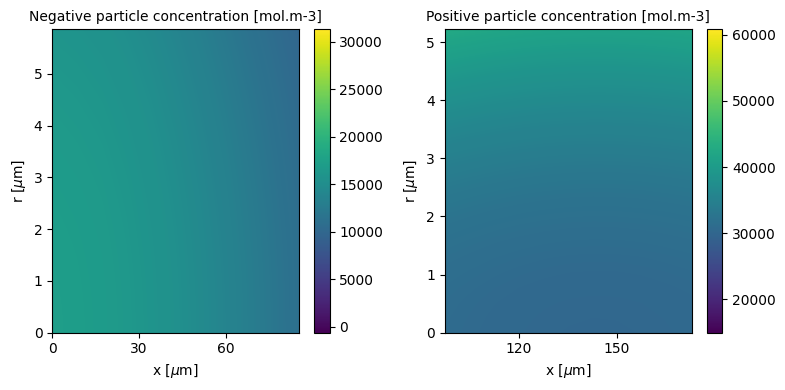

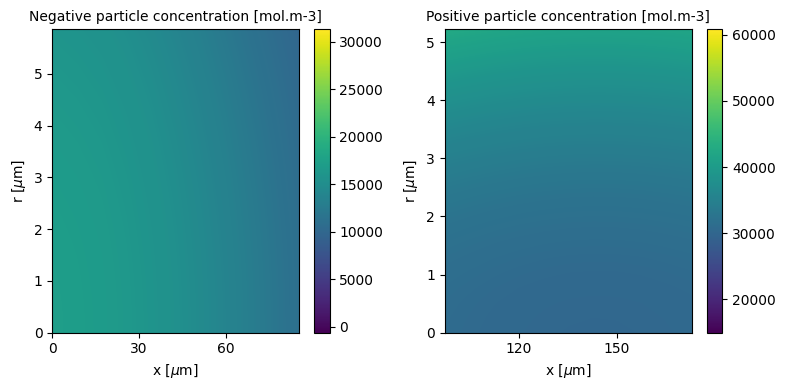

In [96]:
Vars = [
    "Negative particle concentration [mol.m-3]",
    "Positive particle concentration [mol.m-3]",
]
quick_plot = pybamm.QuickPlot(Sol_Linear[0], Vars,variable_limits='fixed') #     
quick_plot.plot(2000)
quick_plot = pybamm.QuickPlot(Sol_Linear[-1], Vars,variable_limits='fixed') #     
quick_plot.plot(2000)

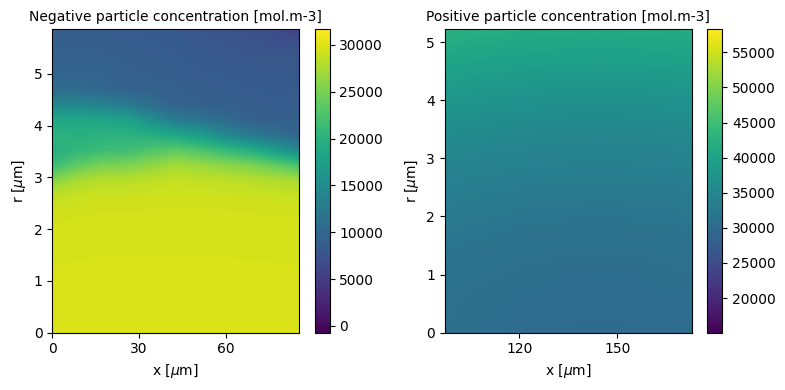

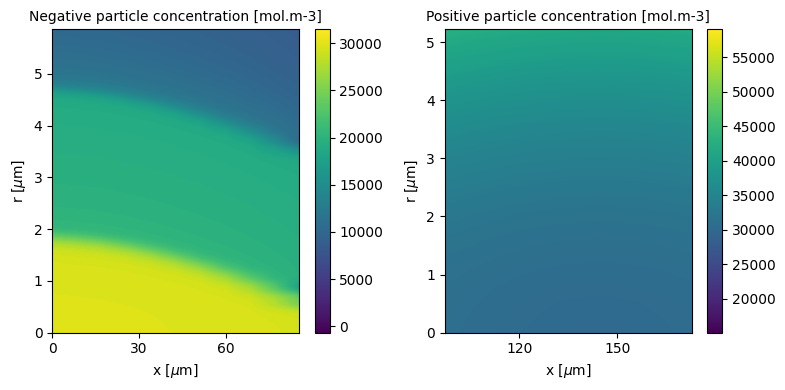

In [97]:
Vars = [
    "Negative particle concentration [mol.m-3]",
    "Positive particle concentration [mol.m-3]",
]
quick_plot = pybamm.QuickPlot(Sol_NonLinear[0], Vars,variable_limits='fixed') #     
#quick_plot.dynamic_plot();
quick_plot.plot(2000)
quick_plot = pybamm.QuickPlot(Sol_NonLinear[-1], Vars,variable_limits='fixed') #     
quick_plot.plot(2000)